In [1]:
%matplotlib notebook
import control as c
import ipywidgets as w
import numpy as np

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#display(HTML('<script> $(document).ready(function() { $(\"div.input\").hide(); }); </script>'))

# Toggle cell visibility
from IPython.display import HTML
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.input').hide()
    } else {
        $('div.input').show()
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Promijeni vidljivost <a href="javascript:code_toggle()">ovdje</a>.''')
display(tag)


## Stvaranje PI-regulatora korištenjem operacijskih pojačala

U analognoj elektronici, operacijska pojačala uobičajeno se koriste za realizaciju proporcionalno-integracijski-derivacijskih (PID) regulatora. Dok matematički modeli linearnih vremenski-nepromjenjivih (LTI) sustava pretpostavljaju idealne uvjete, realni sklopovi možda im ne odgovaraju u potpunosti.

U većini slučajeva idealni model daje prihvatljive rezultate, ali frekvencijske karakteristike mogu se bolje aproksimirati proširivanjem modela s pojačanjem otvorene petlje:
<br><br>
$$G_{ideal}(s)=\frac{V_{out}}{V_{in}}=-\frac{Z_F}{Z_G}\qquad\qquad G_{approx}(s)=\frac{V_{out}}{V_{in}}=-\frac{\frac{-A\cdot Z_F}{Z_G+Z_F}}{1+\frac{A\cdot Z_G}{Z_G+Z_F}}$$
<br>

U ovom ćemo primjeru istražiti neke od konfiguracija PI regulatora zasnovanih na operacijskim pojačalima.<br>
<b>Prvo, odaberite vrijednost pojačanja otvorene petlje za prikazane izračune!</b>



In [2]:
# Model selector
opampGain = w.ToggleButtons(
    options=[('10 000', 10000), ('50 000', 50000), ('200 000', 200000),],
    description='Pojačanje operacijskog pojačala: ', style={'description_width':'30%'})

display(opampGain)

ToggleButtons(description='Pojačanje operacijskog pojačala: ', options=(('10 000', 10000), ('50 000', 50000), …

PI regulator može se implementirati pomoću otpornika u unaprijednoj vezi i kondenzatora u povratnoj vezi. Idealni model točno odgovara matematičkom obliku regulatora. Ali, nakon uključivanja pojačanja otvorene petlje, integrator se zamjenjuje sustavom prvog reda s ogromnom vremenskom konstantom, ograničavajući na taj način amplitudu na niskim frekvencijama.
<br><br>
<img src="Images/int1.png" width="30%" />
<br>
<b>Prilagodite pasivne komponente tako da neidealni model bude najbliži idealnom! Gdje karakteristike značajno odstupaju od idealnih? Što se može reći o grafu faze?</b>

<IPython.core.display.Javascript object>


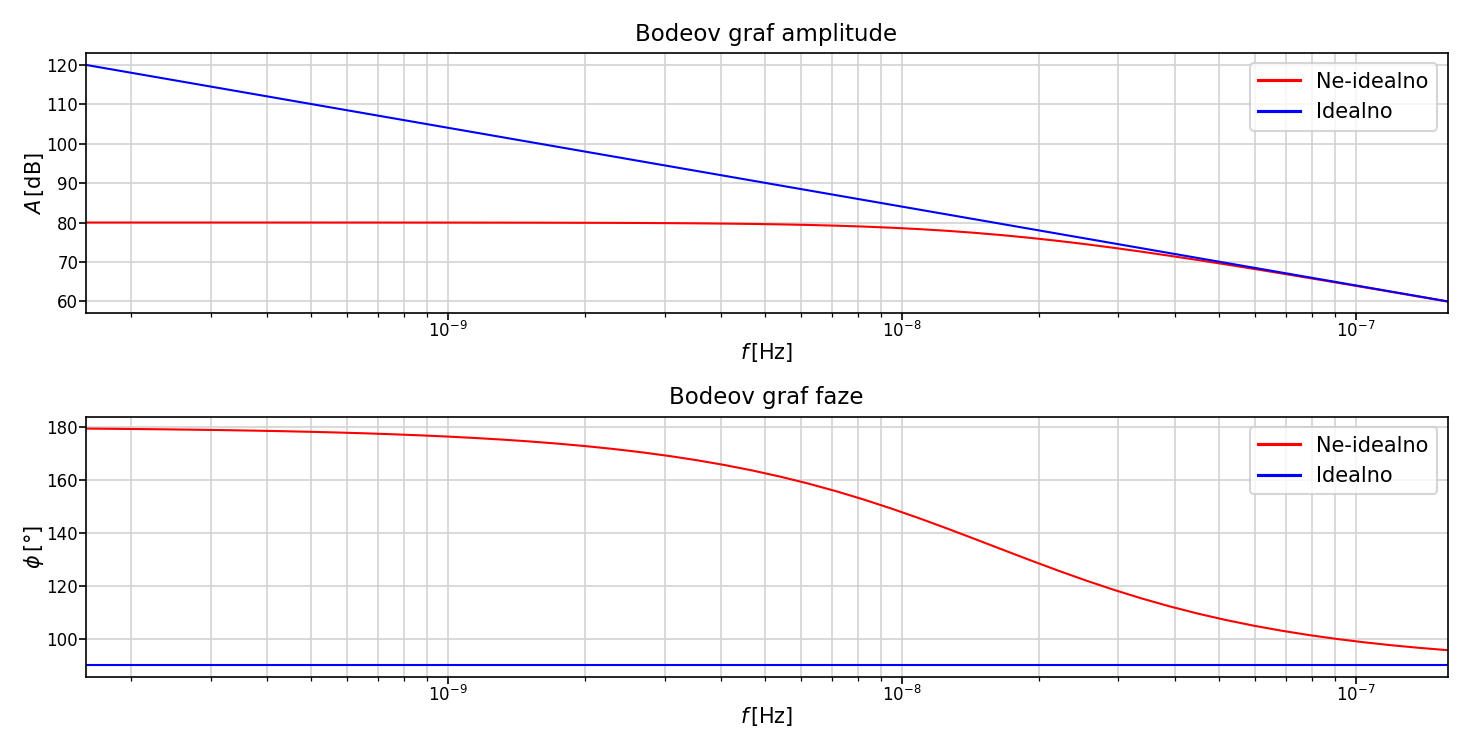

Output()

In [3]:
# Figure definition

fig1, ((f1_ax1), (f1_ax2)) = plt.subplots(2, 1)
fig1.set_size_inches((9.8, 5))
fig1.set_tight_layout(True)

l1 = f1_ax1.plot([], [], color='red')
l2 = f1_ax2.plot([], [], color='red') 
l3 = f1_ax1.plot([], [], color='blue')
l4 = f1_ax2.plot([], [], color='blue')  

f1_line1 = l1[0]
f1_line2 = l2[0]
f1_line3 = l3[0]
f1_line4 = l4[0]
    
f1_ax1.legend(l1+l3, ['Ne-idealno', 'Idealno'], loc=1)
f1_ax2.legend(l2+l4, ['Ne-idealno', 'Idealno'], loc=1)

f1_ax1.grid(which='both', axis='both', color='lightgray')
f1_ax2.grid(which='both', axis='both', color='lightgray')

f1_ax1.autoscale(enable=True, axis='x', tight=True)
f1_ax2.autoscale(enable=True, axis='x', tight=True)
f1_ax1.autoscale(enable=True, axis='y', tight=False)
f1_ax2.autoscale(enable=True, axis='y', tight=False)

f1_ax1.set_title('Bodeov graf amplitude', fontsize=11)
f1_ax1.set_xscale('log')
f1_ax1.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f1_ax1.set_ylabel(r'$A\/$[dB]', labelpad=0, fontsize=10)
f1_ax1.tick_params(axis='both', which='both', pad=0, labelsize=8)

f1_ax2.set_title('Bodeov graf faze', fontsize=11)
f1_ax2.set_xscale('log')
f1_ax2.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f1_ax2.set_ylabel(r'$\phi\/$[°]', labelpad=0, fontsize=10)
f1_ax2.tick_params(axis='both', which='both', pad=0, labelsize=8) 

# System model

def system_model(rg, cf, a):

    Rg = rg / 1000   # Convert to Ohm
    Cf = cf * 1000000   # Convert to Farad

    W_ideal = c.tf([-1], [Rg*Cf, 0])
    W_ac = c.tf([-a], [Cf*Rg*(1+a), 1])
    
    global f1_line1, f1_line2, f1_line3, f1_line4
    
    f1_ax1.lines.remove(f1_line1)
    f1_ax2.lines.remove(f1_line2)
    f1_ax1.lines.remove(f1_line3)
    f1_ax2.lines.remove(f1_line4)

    mag, phase, omega = c.bode_plot(W_ac, Plot=False)   # Non-ideal Bode-plot
    f1_line1, = f1_ax1.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='red')
    f1_line2, = f1_ax2.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='red') 
    
    mag, phase, omega = c.bode_plot(W_ideal, omega=omega, Plot=False)   # Ideal Bode-plot at the non-ideal points
    f1_line3, = f1_ax1.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='blue')
    f1_line4, = f1_ax2.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='blue')   

    f1_ax1.relim()
    f1_ax2.relim()
    
    f1_ax1.autoscale_view()
    f1_ax2.autoscale_view()
    
    print('Prijenosna funkcija za idealni PI:')
    print(W_ideal)
    print('\nPrijenosna funkcija za ne-idealni PI:')
    print(W_ac)
    
# GUI widgets
    
rg_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description=r'$R_g\ [k\Omega]\ :$', continuous_update=False,
                             layout=w.Layout(width='75%'), style={'description_width':'30%'})
cf_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description=r'$C_f\ [\mu H]\ :$', continuous_update=False,
                             layout=w.Layout(width='75%'), style={'description_width':'30%'})

input_data = w.interactive_output(system_model, {'rg':rg_slider, 'cf':cf_slider, 'a':opampGain})

display(w.HBox([rg_slider, cf_slider]), input_data)

Ovaj PI regulator može biti jednostavan, ali nije moguće kontrolirati DC pojačanje putem pasivnih komponenata. Zbog toga se obično u povratnu vezu paralelno spaja odgovarajući otpornik.
<br><br>
<img src="Images/int2.png" width="30%" />
<br>
<b>Prilagodite pasivne komponente tako da neidealni model bude najbliži idealnom! Koje su razlike s obzirom na prethodni model?</b>

<IPython.core.display.Javascript object>


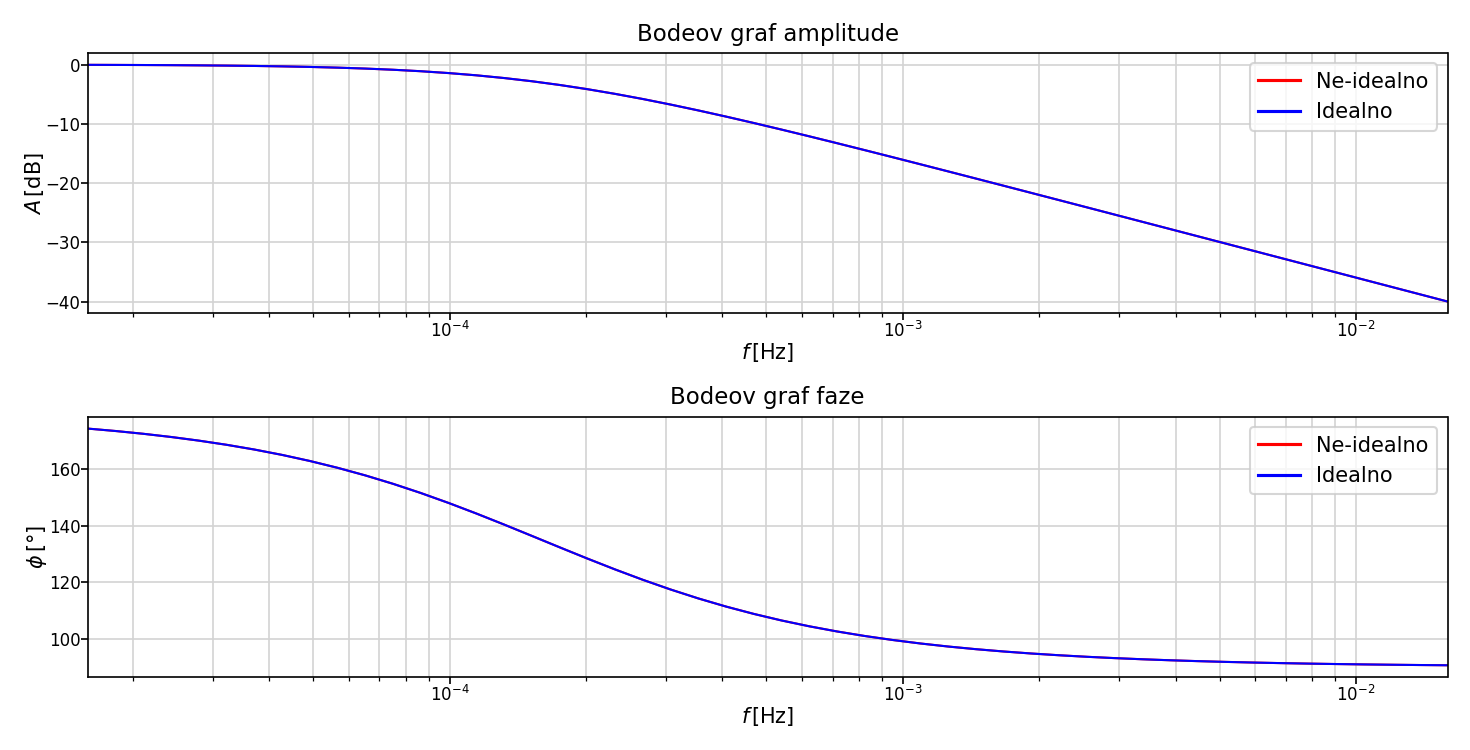

Output()

In [4]:
# Filtered PI - parallel

fig2, ((f2_ax1), (f2_ax2)) = plt.subplots(2, 1)
fig2.set_size_inches((9.8, 5))
fig2.set_tight_layout(True)

l1 = f2_ax1.plot([], [], color='red')
l2 = f2_ax2.plot([], [], color='red') 
l3 = f2_ax1.plot([], [], color='blue')
l4 = f2_ax2.plot([], [], color='blue')  

f2_line1 = l1[0]
f2_line2 = l2[0]
f2_line3 = l3[0]
f2_line4 = l4[0]

f2_ax1.legend(l1+l3, ['Ne-idealno', 'Idealno'], loc=1)
f2_ax2.legend(l2+l4, ['Ne-idealno', 'Idealno'], loc=1)

f2_ax1.grid(which='both', axis='both', color='lightgray')
f2_ax2.grid(which='both', axis='both', color='lightgray')

f2_ax1.autoscale(enable=True, axis='x', tight=True)
f2_ax2.autoscale(enable=True, axis='x', tight=True)
f2_ax1.autoscale(enable=True, axis='y', tight=False)
f2_ax2.autoscale(enable=True, axis='y', tight=False)

f2_ax1.set_title('Bodeov graf amplitude', fontsize=11)
f2_ax1.set_xscale('log')
f2_ax1.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f2_ax1.set_ylabel(r'$A\/$[dB]', labelpad=0, fontsize=10)
f2_ax1.tick_params(axis='both', which='both', pad=0, labelsize=8)

f2_ax2.set_title('Bodeov graf faze', fontsize=11)
f2_ax2.set_xscale('log')
f2_ax2.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f2_ax2.set_ylabel(r'$\phi\/$[°]', labelpad=0, fontsize=10)
f2_ax2.tick_params(axis='both', which='both', pad=0, labelsize=8)

# System model

def system2_model(rg, rf, cf, a):

    Rg = rg / 1000   # Convert to Ohm
    Rf = rf / 1000
    Cf = cf * 1000000   # Convert to Farad

    W_ideal = c.tf([-1], [Rg*Cf, Rg/Rf])
    W_ac = c.tf([-a], [Cf*Rg*(a+1), Rg*(a+1)/Rf+1])
    
    global f2_line1, f2_line2, f2_line3, f2_line4
    
    f2_ax1.lines.remove(f2_line1)
    f2_ax2.lines.remove(f2_line2)
    f2_ax1.lines.remove(f2_line3)
    f2_ax2.lines.remove(f2_line4)

    mag, phase, omega = c.bode_plot(W_ac, Plot=False)   # Non-ideal Bode-plot
    f2_line1, = f2_ax1.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='red')
    f2_line2, = f2_ax2.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='red') 
    
    mag, phase, omega = c.bode_plot(W_ideal, omega=omega, Plot=False)   # Ideal Bode-plot at the non-ideal points
    f2_line3, = f2_ax1.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='blue')
    f2_line4, = f2_ax2.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='blue')   

    f2_ax1.relim()
    f2_ax2.relim()

    f2_ax1.autoscale_view()
    f2_ax2.autoscale_view()
    
    print('Prijenosna funckija za idealni filtrirani PI:')
    print(W_ideal)
    print('\nPrijenosna funckija za ne-idealni filtrirani PI::')
    print(W_ac)
    
# GUI widgets
    
rg2_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description=r'$R_g$ [k$\Omega$]', continuous_update=False,
                             layout=w.Layout(width='75%'), style={'description_width':'30%'})
rf2_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description=r'$R_f$ [k$\Omega$]', continuous_update=False,
                             layout=w.Layout(width='75%'), style={'description_width':'30%'})
cf2_slider = w.FloatLogSlider(value=1, base=10, min=-3, max=3, description=r'$C_f$ [$\mu$H]', continuous_update=False,
                             layout=w.Layout(width='75%'), style={'description_width':'30%'})

input_data = w.interactive_output(system2_model, {'rg':rg2_slider, 'rf':rf2_slider, 'cf':cf2_slider, 'a':opampGain})

display(w.HBox([rg2_slider, rf2_slider, cf2_slider]), input_data)